## X) WILEY

### X.Y) WILEY cleaning and splitting
The core part of this section is altered from a [notebook](https://github.com/Jozefov/mass-spectra-prediction-GCN/blob/master/Notebooks/data_preprocessing.ipynb) created by Filip Jozefov.

- in this subsection we use our in-house copy of the WILEY dataset that is annotated with SMILES using the MSMetaEnhancer tool
- we canonize the smiles strings and remove stereochemistry information
- we split the remaining data in the 0.8:0.1:0.1 ratio according to the train, validation, and test sets of the NIST dataset splitted earlier

In [2]:
import sys
sys.path.append('..')

from matchms.importing import load_from_msp
from matchms.exporting import save_as_msp
from matchms import Spectrum
import matchms

import pandas as pd
from rdkit import Chem

import numpy as np
import os
import random
import pandas as pd
from tqdm import tqdm

import matplotlib.pyplot as plt

from utils.spectra_process_utils import remove_stereochemistry_and_canonicalize

tqdm.pandas()

In [10]:
PROJECT_ROOT = '/home/xhajek9/gc-ms_bart/clean_paper' # TODO: change this to the path of your project root
WILEY_PATH = "../data/datasets/WILEY/20240207_wiley_highres_annotations_all.msp"
NIST_TRAIN_PATH = '../clean_paper/data/nist/train.jsonl'
NIST_TEST_PATH = '../clean_paper/data/nist/test.jsonl'
NIST_VAL_PATH = '../clean_paper/data/nist/valid.jsonl'
SEED = 42

In [8]:
wiley_dataset = list(load_from_msp(WILEY_PATH, metadata_harmonization=False))

In [11]:
nist_train = pd.read_json(NIST_TRAIN_PATH, lines=True)
nist_test = pd.read_json(NIST_TEST_PATH, lines=True)
nist_valid = pd.read_json(NIST_VAL_PATH, lines=True)

In [12]:
np.random.seed(SEED)
random.seed(SEED)

#### Inspection of missing identifiers

In [13]:
# count examined occurrences of specific data missing in our dataset
def count_all(dataset):
    
    all_data = 0

    no_smiles = 0
    no_inchikey = 0
    no_inchi = 0

    no_smile_only = 0
    no_inchikey_only = 0
    both_missing_counter = 0

    all_identifier_missing = 0

    for obj in dataset:
        if obj.get('smiles') == None:
            no_smiles += 1
        if obj.get('inchikey') == None:
            no_inchikey += 1
        if obj.get('inchi') == None:
            no_inchi += 1
        if obj.get('smiles') == None and obj.get('inchi') != None:
            no_smile_only += 1
        if obj.get('smiles') != None and obj.get('inchi') == None:
            no_inchikey_only += 1
        if obj.get('smiles') == None and obj.get('inchikey') != None:
            both_missing_counter += 1
        if obj.get('smiles') == None and obj.get('inchikey') == None and obj.get('inchi') == None:
            all_identifier_missing += 1
        all_data += 1
    return (all_data, no_smiles, no_inchikey, no_inchi, no_smile_only, no_inchikey_only,
            both_missing_counter, all_identifier_missing)

In [15]:
all_data, no_smiles, no_inchikey, no_inchi, no_smile_only, no_inchikey_only,\
            both_missing_counter, all_identifier_missing = count_all(wiley_dataset)

unique_smiles = set([obj.get('smiles') for obj in tqdm(wiley_dataset) if obj.get('smiles') != None])

100%|██████████| 389652/389652 [00:32<00:00, 12024.57it/s]


In [16]:
print(f"We are currently working with {all_data - no_smiles} smiles, from which {len(unique_smiles)} are unique\n")
print(f"We are currently working with {all_data - no_inchikey} inchikeys\n")
print(f"We are currently working with {all_data - no_inchi} inchi\n")

We are currently working with 389652 smiles, from which 344874 are unique

We are currently working with 389652 inchikeys

We are currently working with 389652 inchi



In [17]:
# STATISTICS
data_missing = {
    'All data': [all_data],
    'No smiles': [no_smiles],
    'No inchikey': [no_inchikey],     
    'No inchi': [no_inchi],
    'Smiles Only Missing': [no_smile_only],
    'Inchi Only Missing': [no_inchikey_only],
    'Both Missing': [both_missing_counter],
    'All tree missing': [all_identifier_missing],    
}
missing_df = pd.DataFrame(data_missing)

missing_df = missing_df.T
missing_df.columns = ["Count"]
missing_df["average"] = missing_df.apply(lambda row: row.Count / all_data, axis = 1)

missing_df

,Count,average
All data,389652,1.0
No smiles,0,0.0
No inchikey,0,0.0
No inchi,0,0.0
Smiles Only Missing,0,0.0
Inchi Only Missing,0,0.0
Both Missing,0,0.0
All tree missing,0,0.0


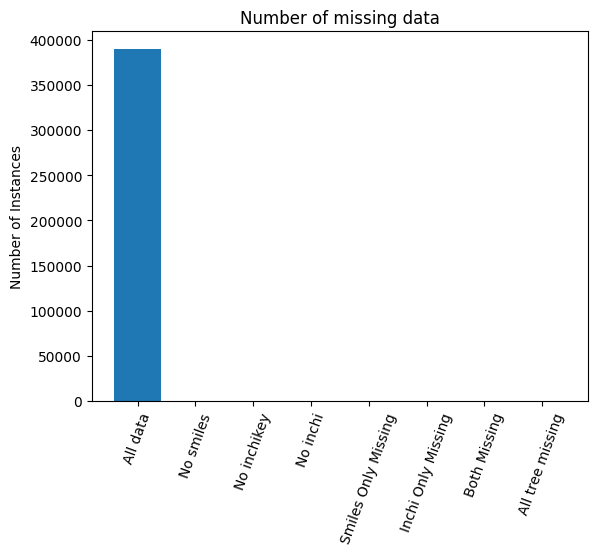

In [18]:
# STATISTICS VISUALIZATION

# x-coordinates of left sides of bars 
parameters_missing = [i for i in range(len(missing_df))]
  
# heights of bars
height = [i for i in missing_df.Count]
  
# labels for bars
tick_label = ['All data', 'No smiles', 'No inchikey', 'No inchi', 'Smiles Only Missing',
              'Inchi Only Missing', 'Both Missing', 'All tree missing']
  

plt.bar(parameters_missing, height, tick_label = tick_label,
        width = 0.8)
  
plt.xlabel('')
plt.xticks(rotation=70)
plt.ylabel('Number of Instances')
plt.title('Number of missing data')
plt.show()

#### Identifier reconstruction

We have approximately 60k data that we are unable to work with. They do not include any identifiers (inchi, inchikey, or SMILES) so we are dropping them. SMILES is crucial for us, so for molecules that don't include a valid SMILES string but include another identifier we will try to reconstruct it. If that fails, we will drop such molecule too.

In [19]:
# Filter and try to restore corupted smiles
# both tools are used, with help of rdkit and matchms as well
# e add the smiles destereo and canonization

def reconstruct_information(dataset):
    updated_dataset = []
    for spectrum in tqdm(dataset):
        smiles = spectrum.get('smiles')
        # all missing
        if smiles == None and spectrum.get('inchikey') == None and spectrum.get('inchi') == None:
            continue
            
        #check weather smiles is syntactically valid or molecule is chemically reasonable
        if (smiles == None or \
            Chem.MolFromSmiles(smiles, sanitize=False) == None or\
            Chem.MolFromSmiles(smiles) == None) and\
            spectrum.get('inchi') != None:
            
            # try to convert from inchi
            tmp = Chem.inchi.MolFromInchi(spectrum.get('inchi'))
            if tmp != None:
                spectrum.set('smiles', Chem.MolToSmiles(tmp))
                smiles = spectrum.get('smiles')
        
        # try with matchms
        if smiles == None and spectrum.get('inchi') != None:
            spectrum = matchms.filtering.derive_smiles_from_inchi(spectrum)
            smiles = spectrum.get('smiles')

        if smiles == None:
            continue
            
        updated_dataset.append(spectrum)
    return updated_dataset

In [20]:
# reconstructed_dataset = reconstruct_information(wiley_dataset)
reconstructed_dataset = wiley_dataset # no need, all SMILES available

100%|██████████| 389652/389652 [01:08<00:00, 5672.93it/s]


In [21]:
print(f"In the dataset there remains {len(reconstructed_dataset)} / {len(wiley_dataset)} molecules and all have now SMILES strings")

In the dataset there remains 389652 / 389652 molecules and all have now SMILES strings


#### Remove stereochemistry and canonicalize smiles

In [37]:
def remove_stereochemistry_and_canonicalize_whole_dataset(dataset):
    updated_dataset = []
    counter_smiles_changed = 0
    for i, spectrum in tqdm(enumerate(dataset)):
        smiles = spectrum.get('smiles')
        if smiles is None:
            raise ValueError("Smiles is None, reconstruction and filtering poorly done.")
        new_smiles = remove_stereochemistry_and_canonicalize(smiles)
        if new_smiles is None:
            continue
        spectrum.set('smiles', new_smiles)
        if new_smiles != smiles:
            counter_smiles_changed += 1
        updated_dataset.append(spectrum)
    print(f"Number of smiles canonicalized or destereochemicalized: {counter_smiles_changed}")
    return updated_dataset

In [38]:
canonicalized_dataset = remove_stereochemistry_and_canonicalize_whole_dataset(reconstructed_dataset)

389652it [02:02, 3184.46it/s]

Number of smiles canonicalized or destereochemicalized: 354916


In [39]:
unique_smiles = set([obj.get('smiles') for obj in tqdm(canonicalized_dataset) if obj.get('smiles') != None])

100%|██████████| 389652/389652 [00:32<00:00, 12021.68it/s]


In [40]:
print(f"In the dataset there remains {len(canonicalized_dataset)} / {len(wiley_dataset)} molecules and all have now canonical SMILES strings")
print(f"\nFrom the remaining there are {len(unique_smiles)} unique SMILES strings.")

In the dataset there remains 389652 / 389652 molecules and all have now canonical SMILES strings

From the remaining there are 334992 unique SMILES strings.


#### NIST aware splitting
In this section, we split the WILEY dataset into train, validation, and test sets but in a way that overlapping parts with the NIST dataset are placed in the same split (valid -> valid, train -> train...) as for the NIST dataset.

In [41]:
TRAIN_RATIO = 0.8
VALID_RATIO = 0.1
TEST_RATIO = 0.1

TRAIN_INDEX = 0
VALID_INDEX = 1
TEST_INDEX = 2

In [42]:
# map each spectrum to its smiles
def unique_mapping(dataset):
    
    smiles_dict = dict()
    counter_none = 0
    
    for spectrum in tqdm(dataset):
        if "smiles" not in spectrum.metadata or spectrum.get("smiles") == None:
            counter_none += 1
            continue
        if spectrum.get("smiles") not in smiles_dict:
            smiles_dict[spectrum.get("smiles")] = [spectrum]
        else:
            smiles_dict[spectrum.get("smiles")].append(spectrum)

    print(f"Missing smiles identifier in {counter_none} cases")
    return smiles_dict

In [61]:
def partition_overlaps(unique_smiles_dict, nist_train_set, nist_valid_set, nist_test_set):
    
    train_set = []
    valid_set = []
    test_set = []
    the_rest = {}
    
    for smiles, spectra in tqdm(unique_smiles_dict.items()):
        if smiles in nist_train_set:
            train_set.extend(spectra)
        elif smiles in nist_valid_set:
            valid_set.extend(spectra)
        elif smiles in nist_test_set:
            test_set.extend(spectra)
        else:
            the_rest[smiles] = spectra
    
    print(f"train_set length: {len(train_set)}")
    print(f"valid_set length: {len(valid_set)}")
    print(f"test_set length: {len(test_set)}")
    print(f"the_rest length: {len(the_rest)}")
    
    return train_set, valid_set, test_set, the_rest

In [75]:
# generate shuffled indices for train, valid and test 
def generate_index(dataset, train_ratio, valid_ratio, test_ratio):
    dataset_length = len(dataset)
    
    train_idx = np.full(int(dataset_length * train_ratio), 0, dtype=int)
    valid_idx = np.full(int(dataset_length * valid_ratio), 1, dtype=int)
    test_idx = np.full(int(dataset_length * test_ratio), 2, dtype=int)
    
    concatenate_array = np.concatenate((train_idx, valid_idx, test_idx))
    
    np.random.shuffle(concatenate_array)
    
    return concatenate_array

In [76]:
# build list dateset for training, valid and test
# we iterate over all cases with same value and append them to final list in way
# that all train, valid and test does not overlap with duplicities 
# at the end, lists are shuffled to avoid continuous stream of same data
def generate_train_test_dataset(dataset, indices):
    
    train = []
    valid = []
    test = []
 
    for i, spectrums in zip(indices, dataset):
        if i == TRAIN_INDEX:
            for spectrum in dataset[spectrums]:
                train.append(spectrum)
        elif i == VALID_INDEX:
            for spectrum in dataset[spectrums]:
                valid.append(spectrum)
        elif i == TEST_INDEX:
            for spectrum in dataset[spectrums]:
                test.append(spectrum)
                
    random.shuffle(train)
    random.shuffle(valid)
    random.shuffle(test)
    return (train, valid, test)

In [44]:
nist_train_set = set(nist_train.smiles)
nist_valid_set = set(nist_valid.smiles)
nist_test_set = set(nist_test.smiles)

  0%|          | 0/389652 [00:00<?, ?it/s]

100%|██████████| 389652/389652 [01:19<00:00, 4910.15it/s]


Missing smiles identifier in 0 cases


100%|██████████| 334992/334992 [00:00<00:00, 1514706.36it/s]

train_set length: 91374
valid_set length: 11447
test_set length: 11513
the_rest length: 275318


In [ ]:
unique_smiles_dict = unique_mapping(canonicalized_dataset)

In [72]:
# filter out (and split) the SMILES already present in the NIST dataset
train_overlapped, test_overlapped, valid_overlapped, the_rest = partition_overlaps(unique_smiles_dict, nist_train_set, nist_test_set, nist_valid_set)

100%|██████████| 334992/334992 [00:00<00:00, 1438072.11it/s]

train_set length: 91374
valid_set length: 11447
test_set length: 11513
the_rest length: 249040


In [73]:
# check intermediate information and compute the new ratios
all_spectra_in_the_rest = sum([len(d) for d in the_rest.values()])
len_all = all_spectra_in_the_rest + len(train_set) + len(valid_set) + len(test_set)
final_train_len = TRAIN_RATIO * len_all
final_valid_len = VALID_RATIO * len_all
final_test_len = TEST_RATIO * len_all

train_to_add = int(final_train_len - len(train_set))
valid_to_add = int(final_valid_len - len(valid_set))
test_to_add = int(final_test_len - len(test_set))


print(f"train_to_add: {train_to_add}")
print(f"valid_to_add: {valid_to_add}")
print(f"test_to_add: {test_to_add}")

print("all to add: ", train_to_add + valid_to_add + test_to_add)
print("all spectra in the_rest: ", all_spectra_in_the_rest)
print("unique smiles in the_rest: ", len(the_rest))

NEW_TRAIN_RATIO = train_to_add / all_spectra_in_the_rest
NEW_VALID_RATIO = valid_to_add / all_spectra_in_the_rest
NEW_TEST_RATIO = (all_spectra_in_the_rest - train_to_add - valid_to_add) / all_spectra_in_the_rest

print(f"new_train_ratio: {NEW_TRAIN_RATIO}")
print(f"new_valid_ratio: {NEW_VALID_RATIO}")
print(f"new_test_ratio: {NEW_TEST_RATIO}")
print(f"sum of new ratios: {NEW_TRAIN_RATIO + NEW_VALID_RATIO + NEW_TEST_RATIO}")

# okay, thats almost the same as the original ratios

train_to_add: 220347
valid_to_add: 27452
test_to_add: 27518
all to add:  275317
all spectra in the_rest:  275318
unique smiles in the_rest:  249040
new_train_ratio: 0.8003363383432975
new_valid_ratio: 0.09971015334994443
new_test_ratio: 0.099953508306758
sum of new ratios: 1.0


In [77]:
# Perform splitting
indices = generate_index(the_rest, NEW_TRAIN_RATIO, NEW_VALID_RATIO, NEW_TEST_RATIO)
train_unique, valid_unique, test_unique = generate_train_test_dataset(the_rest, indices)

In [80]:
train, valid, test = train_overlapped + train_unique, valid_overlapped + valid_unique, test_overlapped + test_unique

#### Save splits to .jsonl files

In [84]:
from utils.spectra_process_utils import extract_spectra
from pathlib import Path

out_dir = Path(PROJECT_ROOT) / "../data" / "datasets" / "WILEY"
for data, data_name in [(valid, "valid"), (test, "test"), (train, "train")]:
    df = extract_spectra(data)
    df["mz"] = df["mz"].apply(lambda x: list(x.round(0)))
    path_jsonl = (out_dir / data_name).with_suffix(".jsonl")
    df.to_json(path_jsonl, orient="records", lines=True)

100%|██████████| 311772/311772 [01:40<00:00, 3093.64it/s]


In [81]:
# no overlap test
len(train), len(valid), len(test), len(set(train) & set(valid)), len(set(train) & set(test)), len(set(valid) & set(test))

(311772, 39043, 38835, 0, 0, 0)

### X.Y) WILEY splits to .smi 
We also save the splits as .smi files for reproducibility.

In [85]:
from utils.spectra_process_utils import jsonl2smi

for dataset_type in ["train", "valid", "test"]:
    jsonl2smi(f"{PROJECT_ROOT}/../data/datasets/WILEY/{dataset_type}.jsonl")